In [2]:
import logging
import os

import numpy as np

from generation.generate import graph_from_file, scenario_from_file
from generation.graphs.fsipp import FSIPP
from generation.railways.train_agents.train_agent_limited_flexiblity import train_agent_limited_flexibility_generator

%load_ext autoreload
%autoreload 2

# Disable logging of the program in the notebook
os.environ["LOGLEVEL"] = "INFO"

logging.basicConfig()
logging.root.setLevel(logging.INFO)
logging.basicConfig(level=logging.INFO)

logger = logging.getLogger('__main__')
logger.setLevel(os.environ.get("LOGLEVEL", logging.INFO))

pybooklogger = logging.getLogger('pybook')
pybooklogger.setLevel(logging.INFO)

import sys
sys.path.append(os.path.abspath(os.path.join(os.path.dirname(os.path.abspath("__file__")), '..')))
save_dir = os.path.join(os.path.dirname(os.path.abspath("__file__")), "results", "corridor")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
# import matplotlib
# matplotlib.use("pgf")
# matplotlib.rcParams.update({
#     "pgf.texsystem": "pdflatex",
#     'font.family': 'serif',
#     'text.usetex': True,
#     'pgf.rcfonts': False,
# })

In [4]:
results_dict = {}
for max_buffer in [0, 3]:
    bg = graph_from_file("../data/paper/location_corridor.json")
    scenario = scenario_from_file("../data/paper/scenario_corridor.json", bg, train_agent_limited_flexibility_generator(max_buffer, 0))
    scenario.process()
    heuristic = {node.name: 0 for node in bg.nodes.values()}
    agent = scenario.get_replanning_agent(1)
    fsipp = FSIPP(scenario.fsipp(agent), heuristic)
    results = fsipp.run_search(1000, agent.origin.name, agent.destination.name, agent.measures.start_time)
    results_dict[max_buffer] = results
    

ERROR:__main__.generation.railways.track_graph:Found platform U|1 on a switch: A: uA or B: uB
ERROR:__main__.generation.railways.track_graph:Found platform V|1 on a switch: A: vA or B: vB
ERROR:__main__.generation.railways.track_graph:Found platform UHAT|1 on a switch: A: uHatA or B: uHatB
ERROR:__main__.generation.railways.track_graph:Found platform VHAT|1 on a switch: A: vHatA or B: vHatB
INFO:__main__.generation.railways.block_graph:  0%|          | 0/24 [00:00<?, ?it/s]
INFO:__main__.generation.railways.block_graph:
INFO:__main__.generation.railways.block_graph:100%|██████████| 24/24 [00:00<00:00, 9607.11it/s]
INFO:__main__.generation.railways.block_graph:



Function <function Scenario.__init__ took 0.0010 seconds
Function <function Scenario.process took 0.0000 seconds
Function <function Scenario.fsipp took 0.0010 seconds


ERROR:__main__.generation.railways.track_graph:Found platform U|1 on a switch: A: uA or B: uB
ERROR:__main__.generation.railways.track_graph:Found platform V|1 on a switch: A: vA or B: vB
ERROR:__main__.generation.railways.track_graph:Found platform UHAT|1 on a switch: A: uHatA or B: uHatB
ERROR:__main__.generation.railways.track_graph:Found platform VHAT|1 on a switch: A: vHatA or B: vHatB
INFO:__main__.generation.railways.block_graph:  0%|          | 0/24 [00:00<?, ?it/s]
INFO:__main__.generation.railways.block_graph:
INFO:__main__.generation.railways.block_graph:100%|██████████| 24/24 [00:00<00:00, 11973.75it/s]
INFO:__main__.generation.railways.block_graph:



Function <function Scenario.__init__ took 0.0010 seconds
Function <function Scenario.process took 0.0005 seconds
Function <function Scenario.fsipp took 0.0000 seconds


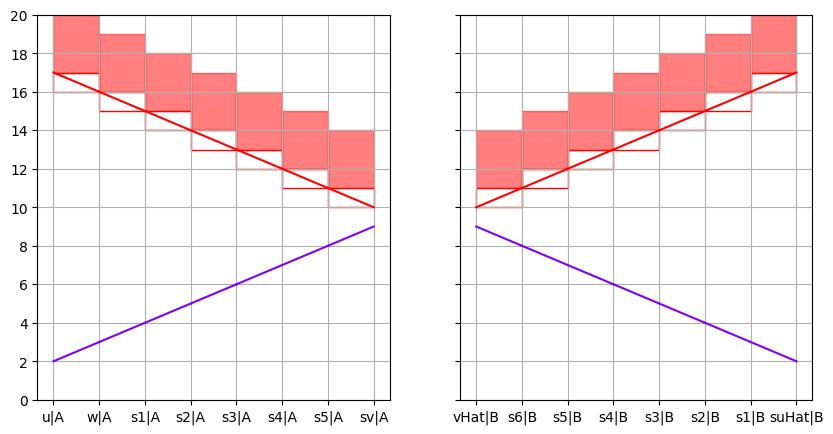

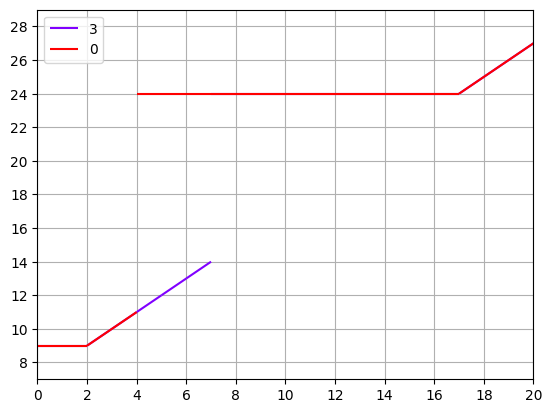

In [5]:
from matplotlib import pyplot as plt, cm

colors = iter(cm.rainbow(np.linspace(0, 1, len(results_dict))))

fig, axs = plt.subplots(1, 2, sharey=True, figsize=(10, 5))
scenario.plot_blocking_staircase(axs[0], 1)
scenario.plot_blocking_staircase(axs[1], 2)
plt.ylim((0,20))
plt.yticks(np.arange(0, 20 + 1, 2))
plt.show()

fig, ax = plt.subplots()
for max_buffer, results in reversed(results_dict.items()):
    results.plot(ax, linestyle=3, color=next(colors), label=max_buffer)
plt.legend()
plt.ylim((7,29))
plt.xlim((0,20))
plt.xticks(np.arange(0, 20 + 1, 2))
plt.yticks(np.arange(8, 29, 2))
plt.grid()
plt.show()